# Petri Net Discovery: Sequencial & Loop & Parallel Workflow Patterns

## Step 1: Setup

In [1]:
import pandas as pd
import pm4py
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.log.util import dataframe_utils
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.visualization.petri_net import visualizer as pn_visualizer

## Step 2: Load Event Log from CSV

In [2]:
df = pd.read_csv("2d_event_log_cleaned.csv", sep=';',parse_dates=["timestamp"])
df

,timestamp,stress,location,event_type,lifecycle,bout_type,action,day,stress_qual,detailed_event_type,simple_event_type,report_case_id,simpler_event_type
0,09/05/2025 08:51,NaN,home,notification,NaN,NaN,RECEIVED,09/05/2025,NaN,notification_RECEIVED,notification_RECEIVED,1,notification_RECEIVED
1,09/05/2025 08:51,NaN,home,notification,NaN,NaN,READ,09/05/2025,NaN,notification_READ,notification_READ,1,notification_READ
2,09/05/2025 08:52,50.0,home,self-report,NaN,NaN,NaN,09/05/2025,high,stress_report_high,self-report_high,1,self-report_high
3,09/05/2025 10:05,NaN,other,physical_activity,START,LIGHT_PA,NaN,09/05/2025,NaN,START_LIGHT_PA,physical_activity_,2,physical_activity_START
4,09/05/2025 10:06,NaN,other,physical_activity,END,LIGHT_PA,NaN,09/05/2025,NaN,END_LIGHT_PA,physical_activity_,2,physical_activity_END
...,...,...,...,...,...,...,...,...,...,...,...,...,...
409,24/05/2025 16:45,NaN,home,notification,NaN,NaN,READ,24/05/2025,NaN,notification_READ,notification_READ,75,notification_READ
410,24/05/2025 16:45,20.0,home,self-report,NaN,NaN,NaN,24/05/2025,low,stress_report_low,self-report_low,75,self-report_low
411,24/05/2025 20:15,NaN,home,notification,NaN,NaN,RECEIVED,24/05/2025,NaN,notification_RECEIVED,notification_RECEIVED,76,notification_RECEIVED
412,24/05/2025 20:47,NaN,home,notification,NaN,NaN,READ,24/05/2025,NaN,notification_READ,notification_READ,76,notification_READ


## Step 3: Prepare the Event Log
PM4Py expects specific column names. Let's rename them and sort the log by time within each case.

In [3]:
# Rename columns to PM4Py convention
df = df.rename(columns={
    "timestamp": "time:timestamp",
    "report_case_id": "case:concept:name",
    "simple_event_type": "concept:name"
})

# Sort by case and time
df = dataframe_utils.convert_timestamp_columns_in_df(df)
df = df.sort_values(by=["case:concept:name", "time:timestamp"])
#df['case:concept:name'] = df['case:concept:name'].dt.strftime('%Y-%m-%d')

# Ensure concept:name is string type
df['concept:name'] = df['concept:name'].astype(str)
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 414 entries, 0 to 91
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   time:timestamp       414 non-null    datetime64[ns, UTC]
 1   stress               48 non-null     float64            
 2   location             414 non-null    object             
 3   event_type           414 non-null    object             
 4   lifecycle            245 non-null    object             
 5   bout_type            245 non-null    object             
 6   action               121 non-null    object             
 7   day                  414 non-null    datetime64[ns, UTC]
 8   stress_qual          48 non-null     object             
 9   detailed_event_type  414 non-null    object             
 10  concept:name         414 non-null    object             
 11  case:concept:name    414 non-null    int64              
 12  simpler_event_type   414 non

## Step 4: Convert to PM4Py Event Log

In [4]:
from pm4py.objects.conversion.log import converter as log_converter

event_log = log_converter.apply(df, variant=log_converter.Variants.TO_EVENT_LOG)

## Step 5: Discover the Process Tree Using Inductive Miner

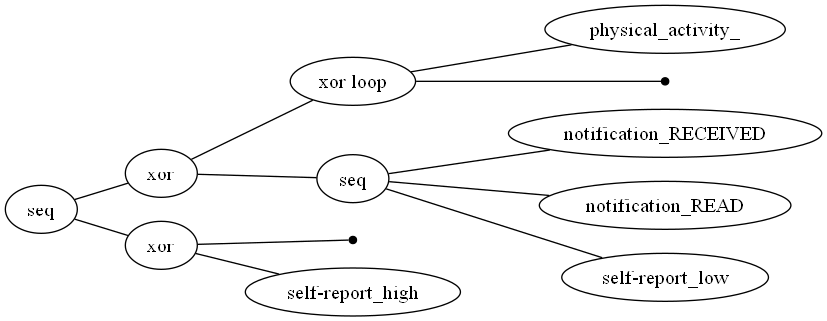

In [8]:
## Discover Process Model
# First get the process tree
from pm4py.algo.discovery.inductive.variants import imf

# Set parameters for the inductive miner
parameters = {
    "noise_threshold": 0.5  # This is the correct parameter name
}

# Apply the inductive miner with parameters
process_tree = inductive_miner.apply(event_log, variant=inductive_miner.Variants.IMf, parameters=parameters)

# Visualize Process Tree
from pm4py.visualization.process_tree import visualizer as pt_visualizer
gviz_pt = pt_visualizer.apply(process_tree)
pt_visualizer.view(gviz_pt)



## Step 6: Converting to Petri Net

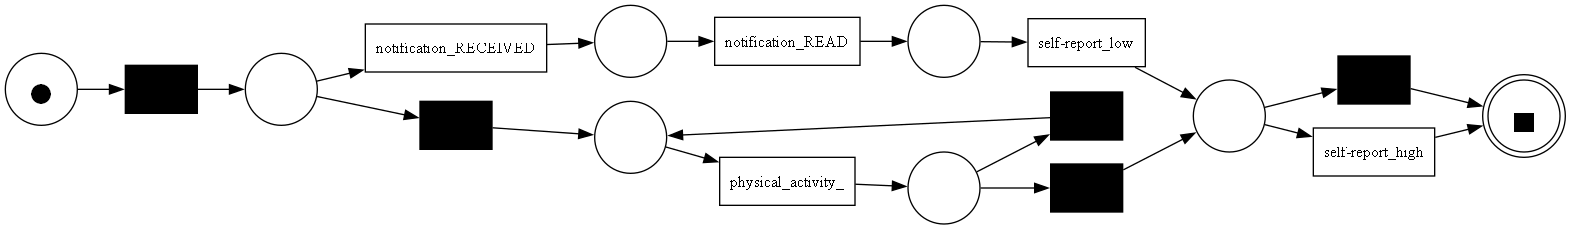

In [9]:
# Convert process tree to Petri net
from pm4py.objects.conversion.process_tree import converter as pt_converter
net, initial_marking, final_marking = pt_converter.apply(process_tree)

# Visualizing
gviz = pn_visualizer.apply(net, initial_marking, final_marking)
pn_visualizer.view(gviz)